# Barlow's equation in conjungtion with the KAPA methods.

The Barlow's equation is used for the compute the internal yield pressure in a tubular-thinned wall cylinder. 

In [44]:
#Importing some modules that will be used later
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

## Barlow as a thick wall hoop stress

Barlow's equation:
$$ p_b = 2\frac{\sigma_y t}{D_0}$$
The previuos expression is widely used to compute the burst pressure. This formula estimate the internal pressure that the pipe withstand given its geometry ($t/D$) and material strength ($\sigma_y$).

In [45]:
def barlow_pressure(sigma ,thickness ,diameter):
    return 2.* sigma * thickness / diameter

### Case of study

For the sake of have a better understanding, lets consider the following crack profile on a 30" diameter pipe with a wall thickness of 0.375". Also, for the pipe let us consider a SMYS of 60100 psi and a design factor of 0.72 for a maximum operating pressure (MOP) of 1503 psi. For this case, we'are going to assume a upper Charpy V-notch (CVN) of 25 ft-lb. 

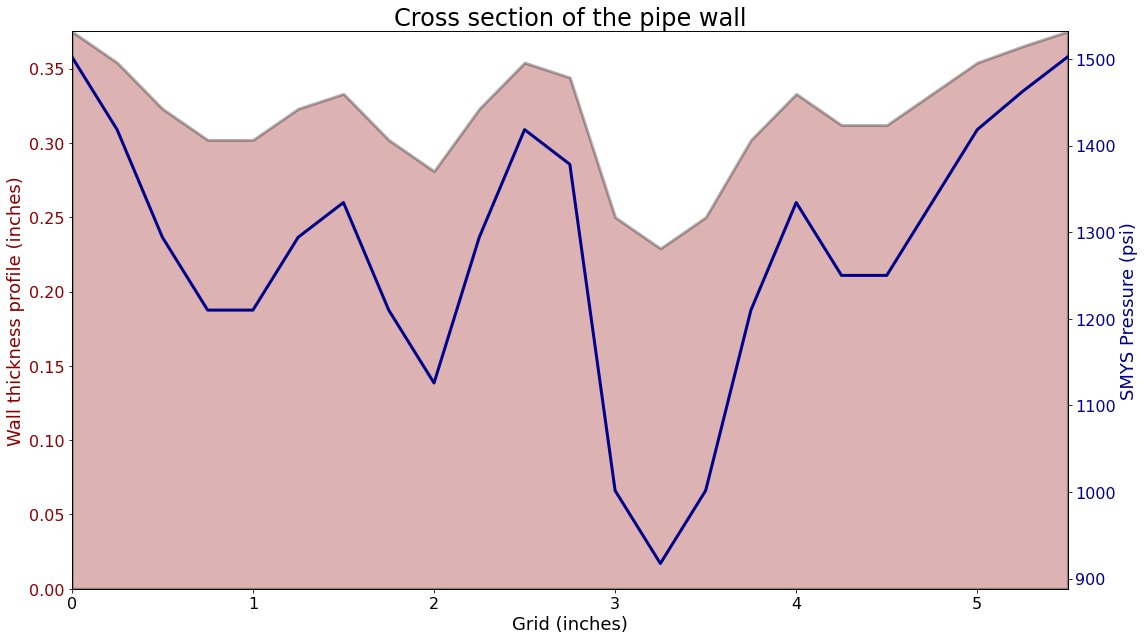

In [46]:
# thickness and diameter are expressed on inches. sigma is expressed in psi.
thickness = 0.375
diameter = 30
sigma = 60100

# Importing some crack profile
cprof = pd.read_excel('test_case.xlsx')

# Computing the SMYS pressure for the following profile
smys_pressure = np.zeros(len(cprof))
for i, i_row in cprof.iterrows():
    smys_pressure[i] = barlow_pressure(sigma, thickness - cprof['depth'][i], diameter)

cprof['smys_pressre'] = smys_pressure

# Plotting the crack profile
color1 = 'darkred'
color2 = 'darkblue'

fig, axs = plt.subplots(figsize=(16,9))

axs.fill_between(cprof['profile_spacing'], thickness - cprof['depth'], 0, linewidth=3, color=color1, alpha=0.3, ec='black')

axs.set_xlabel('Grid (inches)', size=18)
axs.tick_params(axis='x', labelsize=16)
axs.set_ylabel('Wall thickness profile (inches)', size=18, color=color1)
axs.tick_params(axis='y', labelcolor=color1, labelsize=16)

axs.set_xlim(min(cprof['profile_spacing']), max(cprof['profile_spacing']))
axs.set_ylim(0, thickness)

axs1 = axs.twinx()
axs1.plot(cprof['profile_spacing'], cprof['smys_pressre'], linewidth=3, color=color2)

axs1.set_ylabel('SMYS Pressure (psi)', size=18, color=color2)
axs1.tick_params(axis='y', labelcolor=color2, labelsize=16)

plt.title('Cross section of the pipe wall', size=24)
fig.tight_layout()

## KAPA for a crack-like defect.

The failure stress (in psi) computed through the KAPA method, is given by the following equation:

$$ 3\dfrac{\pi \epsilon (C_v/A_v)}{{\bar\sigma}^2L} = \ln\left[\sec\left( \dfrac{\pi}{2}\dfrac{M_p\sigma_p}{\bar\sigma}\right) \right] $$

Where $C_v$ is the upper shelf Charpy V-notch impact energy (ft-lb) and $A_v$ is the area expressed in square inches. $\epsilon$ is the elastic modulus (psi). $\bar \sigma$ flow stress (SMYS + 10 000 psi) (psi) and $\sigma_p$ is the failure stress (psi). With $M_p$ is given by

$$ M_p = \dfrac{1-\frac{A}{A_0}M_T^{-1}}{1-\frac{A}{A_0}} $$ 

$M_T$ si given by:

$$ M_T = \begin{cases} 
\sqrt{1 + 0.62756 \frac{L^2}{Dt} - 0.003375 \left(\frac{L^2}{Dt}\right)^2} & \text{if} &L \leq \sqrt{50 Dt} \\ 
0.032 \frac{L^2}{Dt} + 3.3 & \text{if} &L>\sqrt{50 Dt} 
\end{cases} $$

In [47]:
def kapa_sigma(length, diameter, thickness, sigma_smys ):
    pass